In [1]:
# Load the Datasets
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [2]:
default_batch_size = 64

In [3]:
# Load MNIST
# MNIST transform to preprocess the data
# transforms.Normalize((0.5,),(0.5,) TODO -- put norm back in!
transform_mnist = transforms.Compose([transforms.ToTensor()])

def normalize(x):
    # x = x / 255
    return x

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainset_mnist.data = normalize(trainset_mnist.data)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testset_mnist.data = normalize(testset_mnist.data)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=default_batch_size, shuffle=True)

In [4]:
# VAE Model Definition
class VAE_linear(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE_linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device))  # x2 for mean and variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
    
# VAE Loss function
def vae_loss_function(recon_x, x, mu, log_var, input_size):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

In [5]:
# VAE Training function
def train_vae_linear(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            inputs = Variable(inputs)

            # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            totalloss = BCE + KLD

            # Backward pass
            totalloss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), totalloss.item()))

In [6]:
# MNIST Data Training
input_size = 28 * 28 # Size of MNIST images - 784
hidden_size = 512 # Hidden size for hidden layer
latent_size = 128 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 1 # Number of epochs to train for

# Initialize the model
vae_model_mnist = VAE_linear(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_mnist.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_mnist, trainloader_mnist, optimizer, num_epochs, input_size)

Epoch [1/1], Step [1/938], BCE: 34834.1953, KLD: 15.7491, Total Loss: 34849.9453
Epoch [1/1], Step [501/938], BCE: 10928.5078, KLD: 651.2622, Total Loss: 11579.7695


Average loss: 9327.7837


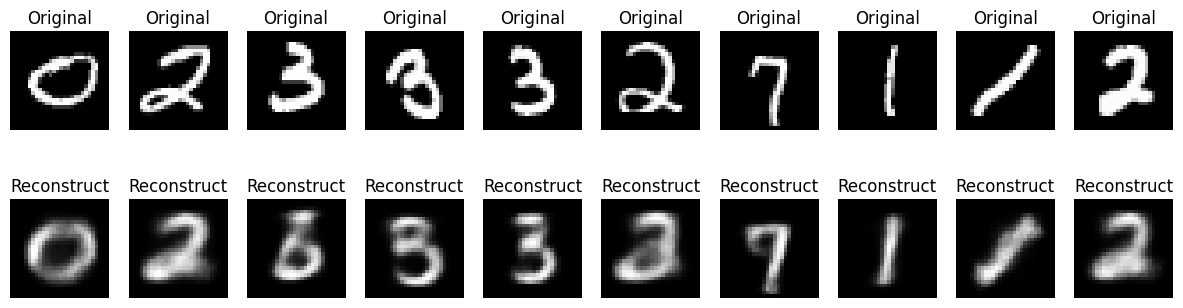

In [7]:
def vae_create_original_and_reconstructed_images_arrays(model, testloader, input_size):
    model.eval()

    # Initialize lists to store original and reconstructed images for testing
    test_original_images = []
    test_reconstructed_images = []

    # Calculate the average reconstruction loss on the testing dataset
    test_average_loss = 0.0
    test_num_batches = 0

    # Evaluate on the entire testing dataset
    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            
            # Forward pass
            recon_batch, mu, log_var = vae_model_mnist(inputs)
            
            # Compute loss
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            loss = BCE + KLD
            test_average_loss += loss.item()
            test_num_batches += 1

            # Convert to numpy arrays for visualization
            test_original_images.append(inputs.cpu().numpy())
            test_reconstructed_images.append(recon_batch.cpu().numpy())

    # Concatenate the batches
    test_original_images = np.concatenate(test_original_images, axis=0)
    test_reconstructed_images = np.concatenate(test_reconstructed_images, axis=0)

    test_average_loss /= test_num_batches
    print('Average loss: {:.4f}'.format(test_average_loss))
    return test_original_images, test_reconstructed_images, test_average_loss

def vae_visualize_original_and_reconstructed(original_images, reconstructed_images, shape, n_samples=10):
    # Select n random images
    indices = np.random.choice(len(original_images), n_samples, replace=False)

    # Plot the original images
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))

    for i, index in enumerate(indices):
        axes[0, i].imshow(original_images[index].reshape(shape), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructed_images[index].reshape(shape), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruct')
    plt.show()

Average loss: 9335.0136


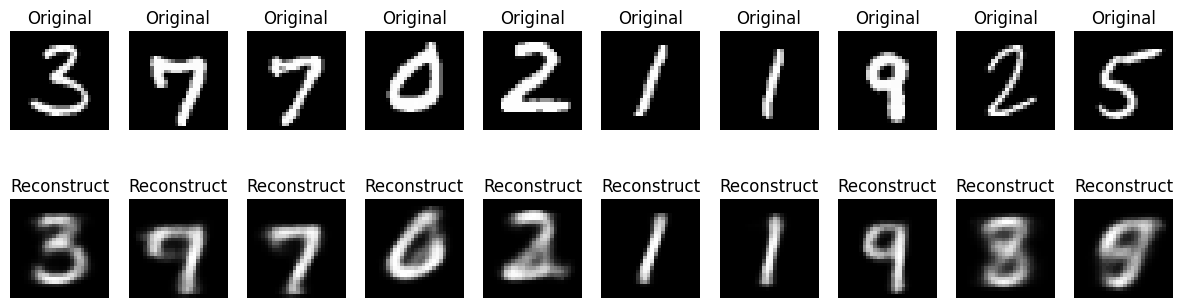

In [8]:
# Visualize the original and reconstructed images -- MNIST
test_original_images, test_reconstructed_images, test_average_loss = vae_create_original_and_reconstructed_images_arrays(vae_model_mnist, testloader_mnist, input_size)
vae_visualize_original_and_reconstructed(test_original_images, test_reconstructed_images, shape=(28,28))